In [36]:
import pandas as pd
import numpy as np
import os, re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [38]:


# ----------------- LOAD -----------------
FILE_PATH_2024 = "../Desktop/(Closed) SMU Mental Health Week 2024 - Survey Form(1-183) (1).xlsx"
df = pd.read_excel(FILE_PATH_2024, sheet_name=0)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Normalize col names: strip, collapse whitespace/newlines
def clean_col(c):
    c = str(c).strip()
    c = re.sub(r"\s+", " ", c)         # collapse multiple spaces & newlines
    return c
df.columns = [clean_col(c) for c in df.columns]

ID_COL = "Id"
# Prompts in 2024 (2 per activity)
LIKERT_FRAGMENTS_2024 = [
    "i found the activity engaging",
    "i will recommend this activity to others",
]

# Free-text columns (best-guess; will auto-shrink to those present)
TEXT_COLS_2024 = [
    "Please share with us key takeaways from SMU Mental Health Week 2024",
    "Please let us know how we can improve SMU Mental Health Week for the SMU community",
    "Any other feedback or comments",
]


In [26]:
df = pd.read_excel(FILE_PATH_2024, sheet_name=0)

def clean_col(c):
    c = str(c).strip()
    c = re.sub(r"\s+", " ", c)   # collapse spaces/newlines
    return c
df.columns = [clean_col(c) for c in df.columns]

if ID_COL not in df.columns:
    df.insert(0, ID_COL, np.arange(1, len(df)+1))

In [27]:
# 1) header-based search for 'email'
email_candidates = [c for c in df.columns if "email" in c.lower()]
# 2) fallback: columns where many cells look like emails
if not email_candidates:
    def looks_like_email_series(s):
        s = s.astype(str)
        return s.str.contains(r'@[^@\s]+\.[^@\s]+', regex=True, na=False).mean()
    ratios = {c: looks_like_email_series(df[c]) for c in df.columns}
    email_candidates = [c for c, r in ratios.items() if r >= 0.4]  # threshold

EMAIL_COL = email_candidates[0] if email_candidates else None
print("Detected EMAIL_COL:", EMAIL_COL)

Detected EMAIL_COL: Email


In [28]:
# ------------------- detect Likert columns -------------------
def is_likert_col(col: str) -> bool:
    lc = col.lower()
    return any(frag in lc for frag in LIKERT_FRAGMENTS_2024)

likert_cols = [c for c in df.columns if is_likert_col(c)]
if len(likert_cols) == 0:
    print("DEBUG: Could not find Likert columns. Sample headers:")
    print(df.columns[:30].tolist())
    raise RuntimeError("No Likert columns detected. Adjust LIKERT_FRAGMENTS_2024 to match your file.")


In [29]:
# ------------------- score Likert -------------------
likert_map = {
    "Strongly agree": 5,
    "Agree": 4,
    "Neutral": 3,
    "Disagree": 2,
    "Strongly disagree": 1,
}
def map_likert(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().title().replace("Stongly", "Strongly")
    return likert_map.get(s, np.nan)

df_scored = df.copy()
for c in likert_cols:
    df_scored[c] = df_scored[c].apply(map_likert)

In [30]:
# ------------------- split Activity.Question safely -------------------
def split_activity_question(col: str):
    if "." in col:
        a, q = col.split(".", 1)
    else:
        lc = col.lower()
        if LIKERT_FRAGMENTS_2024[0] in lc:
            i = lc.index(LIKERT_FRAGMENTS_2024[0])
            a, q = col[:i], col[i:]
        elif LIKERT_FRAGMENTS_2024[1] in lc:
            i = lc.index(LIKERT_FRAGMENTS_2024[1])
            a, q = col[:i], col[i:]
        else:
            a, q = col, "Likert"
    return a.strip(), q.strip()

In [31]:
# ------------------- build tidy (long) -------------------
rows = []
for c in likert_cols:
    a, q = split_activity_question(c)
    for idx, val in df_scored[c].items():
        rows.append({
            ID_COL: df_scored.at[idx, ID_COL],
            "Activity": a,
            "Question": q,
            "Score": val
        })
tidy = pd.DataFrame(rows)
assert ID_COL in tidy.columns and len(tidy) > 0, "Failed to build tidy table."

In [32]:
# ------------------- Faculty + Year from email (robust) -------------------
def extract_faculty(email):
    try:
        email = str(email)
        dom = email.split("@",1)[1].lower()   # e.g., economics.smu.edu.sg
        local = email.split("@",1)[0].lower()
    except Exception:
        return "Unknown"

    tokens = set(dom.split("."))  # {'economics','smu','edu','sg'}
    mapping = {
        "scis":"SCIS","sis":"SCIS",
        "lkcsb":"LKCSB","business":"LKCSB",
        "soa":"SOA","accountancy":"SOA",
        "soe":"SOE","economics":"SOE","econs":"SOE",
        "soss":"SOSS","socsc":"SOSS","socialsciences":"SOSS",
        "sol":"SOL","law":"SOL"
    }
    for t in tokens:
        if t in mapping:
            return mapping[t]
    for t in mapping:   # fallback: sometimes embedded in the local-part
        if t in local:
            return mapping[t]
    return "Unknown"

def extract_entry_year(local_part):
    m = re.search(r"(20\d{2})", str(local_part))
    return int(m.group(1)) if m else None

def derive_year_of_study(email, current_year=2025):
    try:
        entry = extract_entry_year(str(email).split("@",1)[0])
        if entry and 2015 <= entry <= current_year:
            yos = (current_year - entry) + 1
            return min(max(yos,1),6)
        return np.nan
    except Exception:
        return np.nan

if EMAIL_COL is not None:
    df_scored["Faculty"] = df_scored[EMAIL_COL].apply(extract_faculty)
    df_scored["YearOfStudy"] = df_scored[EMAIL_COL].apply(derive_year_of_study)
else:
    df_scored["Faculty"] = "Unknown"
    df_scored["YearOfStudy"] = np.nan

print("Faculty sample:", df_scored["Faculty"].value_counts(dropna=False).head())

Faculty sample: Faculty
Unknown    183
Name: count, dtype: int64


In [33]:
# respondent-level totals/means
resp_scores = tidy.groupby(ID_COL)["Score"].agg(TotalScore="sum", MeanScore="mean").reset_index()
df_scored = df_scored.merge(resp_scores, on=ID_COL, how="left")

# activity x question means + overall
act_summary = (
    tidy.groupby(["Activity","Question"])["Score"]
        .mean().reset_index()
        .pivot(index="Activity", columns="Question", values="Score")
)
act_summary["Overall (mean of prompts)"] = act_summary.mean(axis=1)


In [34]:
# faculty/year rollups
faculty_summary = tidy.join(
    df_scored.set_index(ID_COL)[["Faculty"]], on=ID_COL
).groupby(["Faculty","Activity"])["Score"].mean().reset_index()

year_summary = tidy.join(
    df_scored.set_index(ID_COL)[["YearOfStudy"]], on=ID_COL
).groupby(["YearOfStudy","Activity"])["Score"].mean().reset_index()

# engagement index (0–100)
engagement_index = tidy.groupby(ID_COL)["Score"].mean() * 20
df_scored["EngagementIndex"] = df_scored[ID_COL].map(engagement_index)

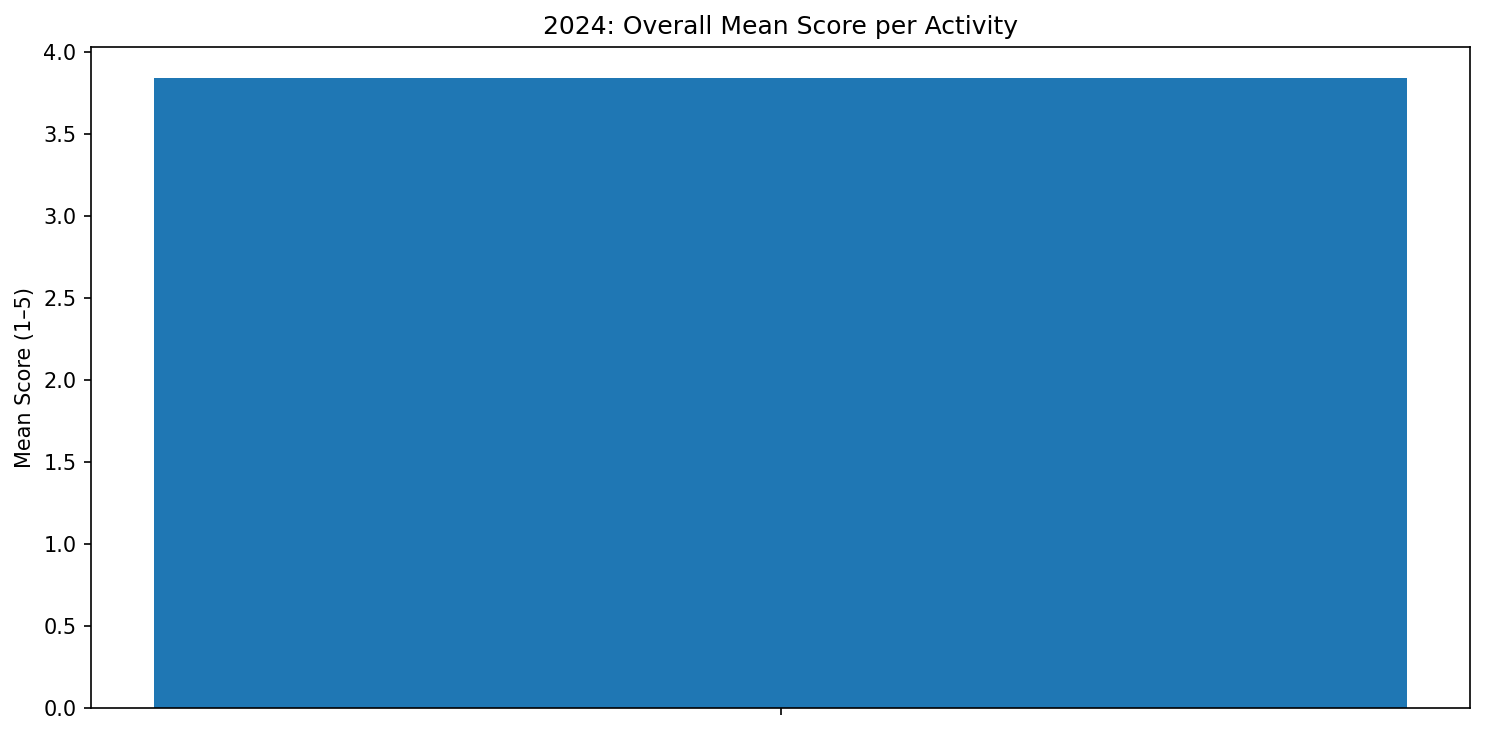

In [39]:
plt.rcParams.update({"figure.dpi": 150})

# A) overall mean per activity (sorted)
act_sorted = act_summary.sort_values("Overall (mean of prompts)", ascending=False)
plt.figure(figsize=(10,5))
plt.bar(range(len(act_sorted.index)), act_sorted["Overall (mean of prompts)"].values)
plt.xticks(range(len(act_sorted.index)), act_sorted.index, rotation=30, ha="right")
plt.ylabel("Mean Score (1–5)")
plt.title("2024: Overall Mean Score per Activity")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "2024_fig_activity_overall_bar.png"))
plt.show()


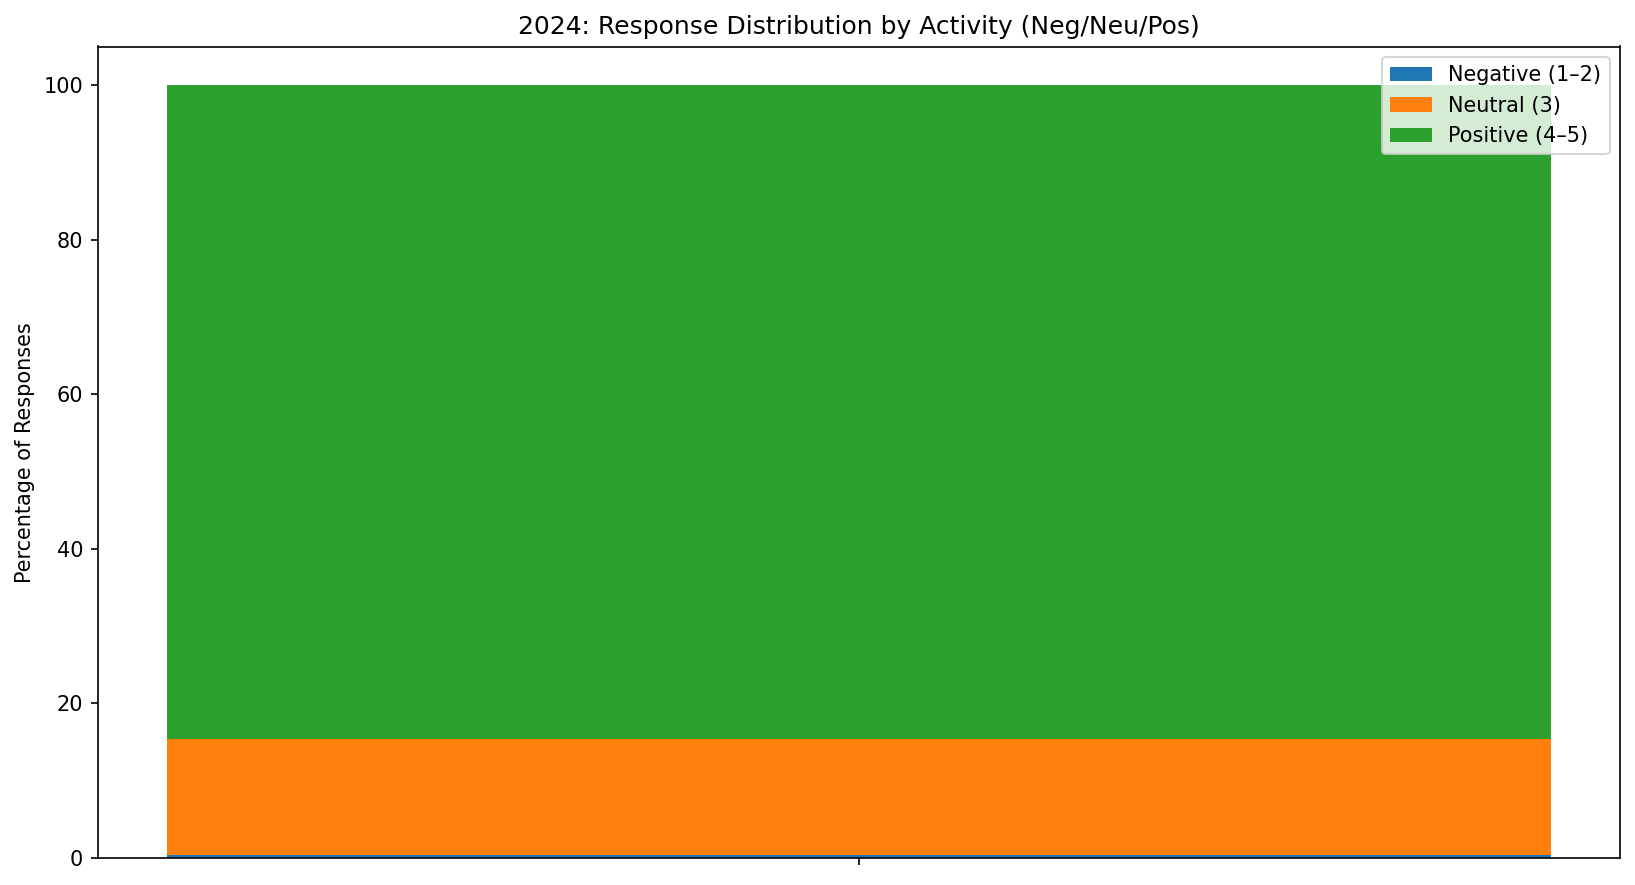

In [40]:
# B) stacked Likert % (Positive/Neutral/Negative)
def band(score):
    if pd.isna(score): return np.nan
    if score <= 2: return "Negative (1–2)"
    if score == 3: return "Neutral (3)"
    return "Positive (4–5)"

tidy["Band"] = tidy["Score"].apply(band)
band_counts = tidy.groupby(["Activity","Band"]).size().unstack(fill_value=0)
band_perc = band_counts.div(band_counts.sum(axis=1), axis=0) * 100
pos_order = band_perc.sort_values("Positive (4–5)", ascending=False).index

plt.figure(figsize=(11,6))
bottom = np.zeros(len(pos_order))
for col in ["Negative (1–2)","Neutral (3)","Positive (4–5)"]:
    vals = band_perc[col].reindex(pos_order).fillna(0).values if col in band_perc else np.zeros(len(pos_order))
    plt.bar(range(len(pos_order)), vals, bottom=bottom, label=col)
    bottom += vals
plt.xticks(range(len(pos_order)), pos_order, rotation=30, ha="right")
plt.ylabel("Percentage of Responses")
plt.title("2024: Response Distribution by Activity (Neg/Neu/Pos)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "2024_fig_activity_stacked_perc.png"))
plt.show()

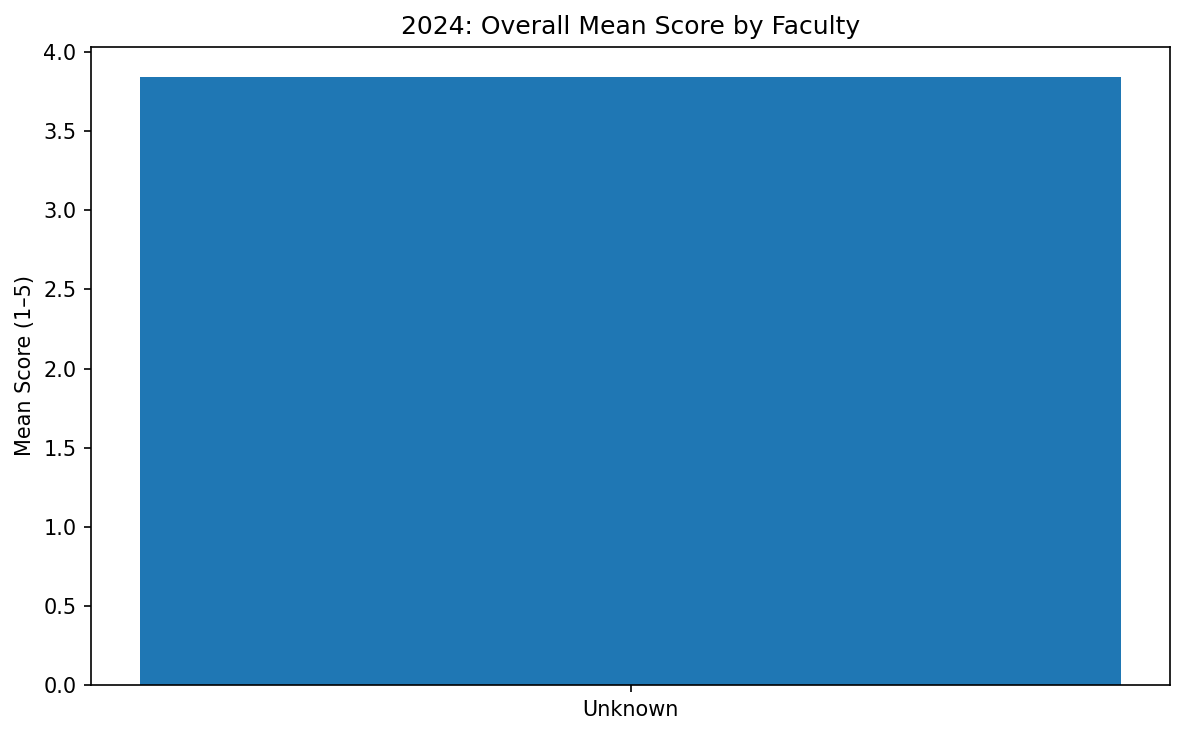

In [41]:
# C) faculty overall means
fac_overall = tidy.join(
    df_scored.set_index(ID_COL)[["Faculty"]], on=ID_COL
).groupby("Faculty")["Score"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(fac_overall.index, fac_overall.values)
plt.ylabel("Mean Score (1–5)")
plt.title("2024: Overall Mean Score by Faculty")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "2024_fig_faculty_overall_bar.png"))
plt.show()

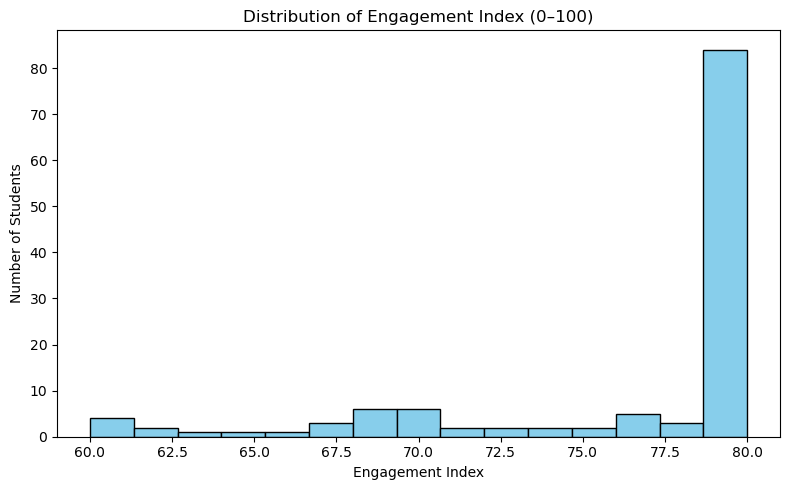

In [18]:
plt.figure(figsize=(8,5))
plt.hist(df_scored["EngagementIndex"].dropna(), bins=15, color="skyblue", edgecolor="black")
plt.title("Distribution of Engagement Index (0–100)")
plt.xlabel("Engagement Index")
plt.ylabel("Number of Students")
plt.tight_layout()
plt.show()


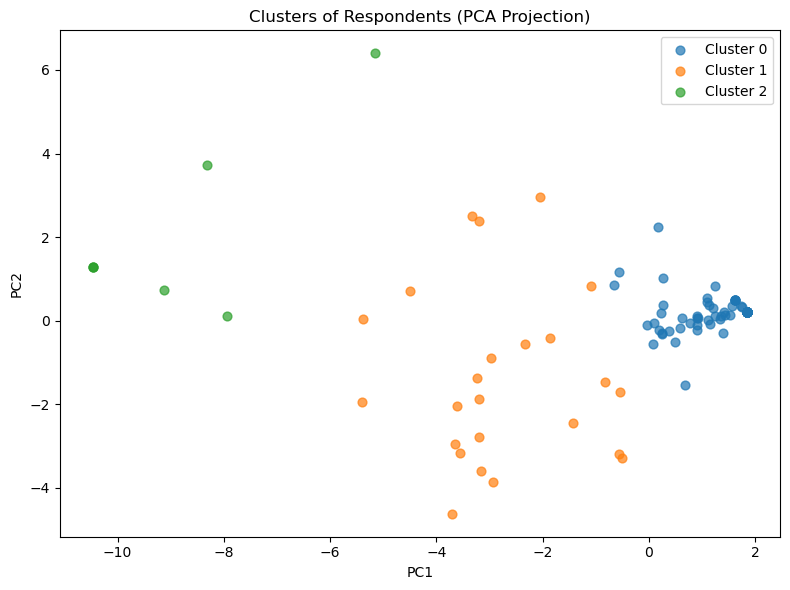

In [19]:


# Prepare data for clustering
wide = tidy.pivot_table(index=ID_COL, columns=["Activity","Question"], values="Score", aggfunc="mean")
col_means = wide.mean(axis=0)
X = wide.fillna(col_means)
X_scaled = StandardScaler().fit_transform(X)

# Run KMeans
k = 3
km = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = km.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot
plt.figure(figsize=(8,6))
for cl in np.unique(labels):
    idx = labels == cl
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=40, alpha=0.7, label=f"Cluster {cl}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters of Respondents (PCA Projection)")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

text_cols = [c for c in TEXT_COLS_2024 if c in df_scored.columns]
if text_cols:
    text_series = df_scored[text_cols].astype(str).apply(lambda s: s.str.strip()).replace({"nan": ""})
    combined_text = text_series.apply(lambda r: " . ".join([x for x in r if x]), axis=1)
    combined_text = combined_text[combined_text.str.len()>0]

    vectorizer = CountVectorizer(stop_words="english", max_df=0.85, min_df=5)
    X_text = vectorizer.fit_transform(combined_text)
    n_topics = 5 if X_text.shape[0] >= 10 else max(1, min(3, X_text.shape[0]))
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X_text)

    terms = np.array(vectorizer.get_feature_names_out())
    for topic_idx, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[-12:][::-1]
        print(f"Topic {topic_idx}: {', '.join(terms[top_idx])}")


Topic 0: activities, engaging, think, nice, event, great, fun, things, better, gratitude, booths, kind
Topic 1: mental, health, nil, important, people, languages, care, love, booths, time, maybe, things
Topic 2: na, fun, learnt, care, support, great, friends, stress, people, grateful, important, nil
Topic 3: nil, good, grateful, kind, time, ways, gratitude, stress, things, think, maybe, great
Topic 4: love, nil, important, language, make, maybe, learned, kind, learnt, booths, friends, better
